## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>

In this mini project, I will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

The dataset contains information about hotel bookings, including the number of adults/children, number of week/weekend nights, type of meal plan, room type, and lead time, etc. as well as whether or not the booking was canceled. The dataset include 18 features and over 18,000 observations, which is large enough to provide a good sample size for the analysis. However, there might be class imbalance between the target classes or missing values, which affects the accuracy of the models and misleads the results. There might also be features that have stronger correlations with the target class or with each other. It will be important to carefully examine the data and any potential biases or data quality issues that may affect the accuracy of the predictive models.

In [2]:
reservation_df = pd.read_csv("train__dataset.csv")
reservation_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


<br><br>

## 2. Data splitting <a name="2"></a>
<hr> 

In [3]:
train_df, test_df = train_test_split(reservation_df, test_size=0.2, random_state=123)
train_df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
800,2,0,1,3,0,0,0,23,2018,1,7,1,0,0,0,87.0,2,0
13544,1,0,0,1,0,0,0,15,2018,2,19,2,0,0,0,81.0,0,0
14555,1,0,1,1,0,0,0,3,2017,11,23,2,1,0,1,65.0,0,0
11224,2,0,0,2,0,0,1,148,2018,7,8,1,0,0,0,136.8,1,1
10890,2,1,2,4,0,0,0,61,2018,7,23,1,0,0,0,121.5,0,1


<br><br>

## 3. EDA <a name="3"></a>
<hr>

In [4]:
train_df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000
mean,1.849059,0.107106,0.809566,2.196223,0.319526,0.032532,0.337859,85.211524,2017.821628,7.422979,15.711765,0.803708,0.025364,0.022331,0.153629,103.558628,0.621476,0.325867
std,0.514970,0.398989,0.869672,1.414027,0.630462,0.177413,0.775620,86.901659,0.382839,3.079938,8.759235,0.644105,0.157232,0.359667,1.720322,35.546998,0.789420,0.468714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.600000,1.000000,1.000000
max,4.000000,3.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


There are no missing values so I do not need to perform imputation for these features. It is also worth noting that although all features are numeric-looking, some are actually categorical, which requires different transformers.

In [5]:
train_df["booking_status"].value_counts()

0    9781
1    4728
Name: booking_status, dtype: int64

The positive class (the reservation is canceled) accounts for around one-third (33%) of the dataset, suggesting that there is no severe class imbalance. In fact, the cancellation rate is relatively high.


In [6]:
import seaborn as sns

Text(0.5, 1.0, 'Correlations')

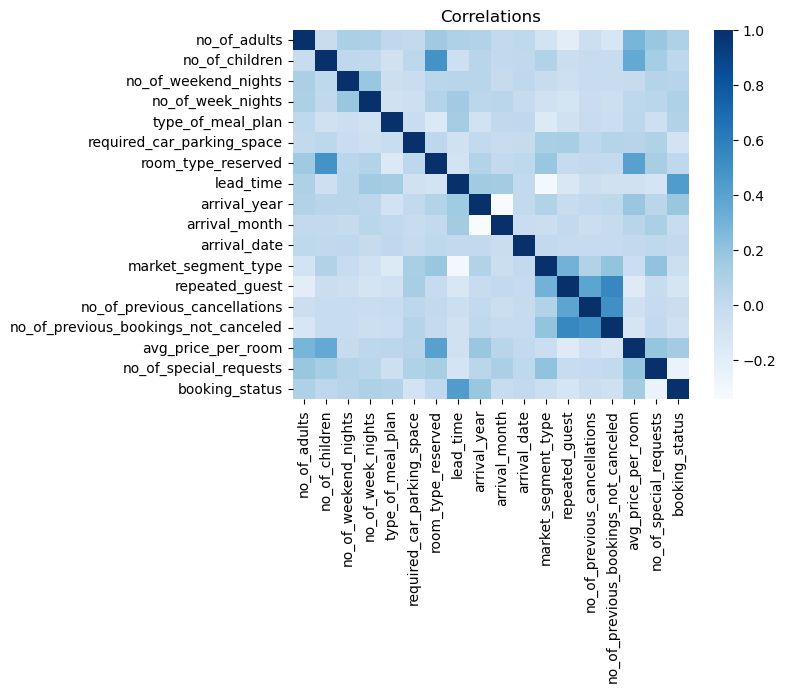

In [7]:
sns.heatmap(train_df.corr(), cmap="Blues")
plt.title("Correlations")

The heatmap shows a strong correlation between `booking_status` and `lead_time`, suggesting that the lead time could be a strong predictor of cancellations. There are also strong correlations between `no_of_previous_cancellations`, `no_of_previous_bookings_not_canceled`, and `repeated_guest`, suggesting that they may be capturing the same information and therefore, some may not be important in predicting `booking_status`.

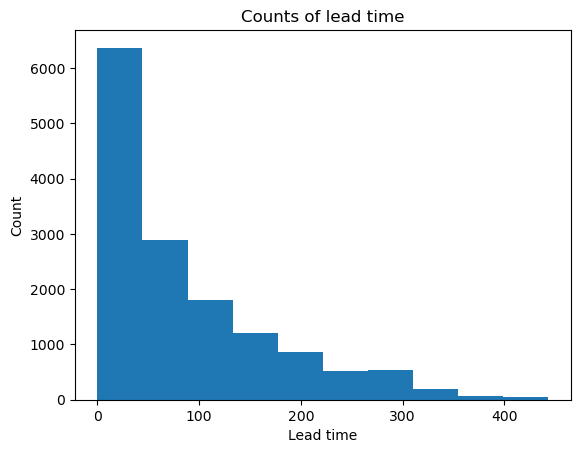

In [8]:
plt.hist(train_df["lead_time"])
plt.title("Counts of lead time")
plt.xlabel("Lead time")
plt.ylabel("Count")
plt.show()

The histogram is skewed to the right, suggesting that many reservations are made close to the arrival date, which may make challenging to detect and prevent cancellations.

In summary, the dataset has no issues with missing values or class imbalance. However, I need to be careful when choosing which transformers to use for what features as they are all numeric-looking. The data suggests that while the lead time could be a strong predictor of cancellations, most reservations are made close to the arrival date, making it harder to predict. In addition, there are some features that may not be important in our prediction.

Given the nature of the problem (identifying potential cancellations) and the high cancellation rate, the goal of our models should be to minimize false negatives (failing to predict a cancellation), so recall may be the most appropriate metric to optimize. I will also look at accuracy for an overall view of how the models are doing.

<br><br>

## 4. Feature engineering <a name="4"></a>
<hr> 

In [9]:
reservation_df["season"] = reservation_df["arrival_month"].apply(lambda x: 
    "winter" if x in [12, 1, 2]
    else "spring" if x in [3, 4, 5]
    else "summer" if x in [6, 7, 8]
    else "fall" if x in [9, 10, 11]
    else None
)

In [10]:
reservation_df["total_guests"] = reservation_df["no_of_adults"] + reservation_df["no_of_children"]

In [11]:
reservation_df["total_length_of_stay"] = reservation_df["no_of_week_nights"] + reservation_df["no_of_weekend_nights"]

In [12]:
train_df, test_df = train_test_split(reservation_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["booking_status"]), train_df["booking_status"]
X_test, y_test = test_df.drop(columns=["booking_status"]), test_df["booking_status"]
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,season,total_guests,total_length_of_stay
800,2,0,1,3,0,0,0,23,2018,1,7,1,0,0,0,87.00,2,winter,2,4
13544,1,0,0,1,0,0,0,15,2018,2,19,2,0,0,0,81.00,0,winter,1,1
14555,1,0,1,1,0,0,0,3,2017,11,23,2,1,0,1,65.00,0,fall,1,2
11224,2,0,0,2,0,0,1,148,2018,7,8,1,0,0,0,136.80,1,summer,2,2
10890,2,1,2,4,0,0,0,61,2018,7,23,1,0,0,0,121.50,0,summer,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,2,0,1,2,0,0,4,94,2018,3,25,1,0,0,0,95.25,0,spring,2,3
7763,2,0,0,4,0,0,1,33,2018,2,23,1,0,0,0,61.60,1,winter,2,4
15377,2,0,1,4,0,0,1,34,2018,4,4,1,0,0,0,131.40,0,spring,2,5
17730,2,0,0,2,0,0,0,12,2017,12,16,0,0,0,0,58.00,0,winter,2,2


<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [13]:
numeric_feats = [
    "no_of_adults",
    "no_of_children",
    "no_of_weekend_nights",
    "no_of_week_nights",
    "lead_time",
    "no_of_previous_cancellations",
    "no_of_previous_bookings_not_canceled",
    "avg_price_per_room",
    "no_of_special_requests",
    "total_guests",
    
] # apply scaling
categorical_feats = [
    "type_of_meal_plan",
    "room_type_reserved",
    "arrival_year",
    "arrival_month",
    "arrival_date",
    "market_segment_type",
    "season",
] # apply one-hot-encoding with drop="first"
passthrough_feats = [
    "required_car_parking_space",
    "repeated_guest",
] # passthrough

In [14]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(drop="first"), categorical_feats),
    ("passthrough", passthrough_feats),
)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
all_models_dict = {}

dc = DummyClassifier()

scores_dc = mean_std_cross_val_scores(
    dc, X_train, y_train, scoring=["accuracy", "recall"], return_train_score=True
)

In [18]:
all_models_dict["dummy"] = scores_dc
pd.DataFrame(all_models_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
dummy,0.005 (+/- 0.005),0.001 (+/- 0.001),0.674 (+/- 0.000),0.674 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


Recall is very bad for the baseline model. Because the model always predicts the majority class (the reservation is not canceled), it is unable to identify any cancellations.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>

In [19]:
C_vals = [0.01, 0.1, 1.0, 10, 100, 1000]

scores_dict = {}

for C_val in C_vals:
    pipe_lr = make_pipeline(
        preprocessor,
        LogisticRegression(max_iter=1000, C=C_val, random_state=123),
    )
    scores = mean_std_cross_val_scores(
        pipe_lr, X_train, y_train, scoring=["accuracy", "recall"], return_train_score=True
    )
    scores_dict[C_val] = scores

In [20]:
pd.DataFrame(scores_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
0.01,0.061 (+/- 0.006),0.015 (+/- 0.006),0.802 (+/- 0.004),0.803 (+/- 0.001),0.595 (+/- 0.012),0.597 (+/- 0.003)
0.10,0.086 (+/- 0.007),0.013 (+/- 0.007),0.810 (+/- 0.005),0.811 (+/- 0.002),0.634 (+/- 0.013),0.635 (+/- 0.005)
1.00,0.180 (+/- 0.012),0.011 (+/- 0.007),0.809 (+/- 0.004),0.811 (+/- 0.001),0.638 (+/- 0.013),0.641 (+/- 0.005)
10.00,0.318 (+/- 0.038),0.009 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)
100.00,0.347 (+/- 0.018),0.011 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)
1000.00,0.328 (+/- 0.079),0.013 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)


In [21]:
all_models_dict["logistic regression"] = scores_dict[100]
pd.DataFrame(all_models_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
dummy,0.005 (+/- 0.005),0.001 (+/- 0.001),0.674 (+/- 0.000),0.674 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,0.347 (+/- 0.018),0.011 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)


Both recall and accuracy have improved from the baseline model. Training and validation scores are very close to each other. Beyond the best value of C=10, both scores remain the same. The standard deviation is low, suggesting that there is little variation in the scores. However, recall is still not very high. Out of all positive examples, I can only identify around 64%. The model may be underfitting.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>

In [22]:
from lightgbm.sklearn import LGBMClassifier

In [23]:
models = {
    "random forest": RandomForestClassifier(random_state=123, n_jobs=-1),
    "lgbm": LGBMClassifier(random_state=123),
    "svm": SVC(random_state=123),
}

In [24]:
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    all_models_dict[model_name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, scoring=["accuracy","recall"], cv=5, return_train_score=True
    )

In [25]:
pd.DataFrame(all_models_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
dummy,0.005 (+/- 0.005),0.001 (+/- 0.001),0.674 (+/- 0.000),0.674 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,0.347 (+/- 0.018),0.011 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)
random forest,2.260 (+/- 1.128),0.044 (+/- 0.007),0.885 (+/- 0.004),0.997 (+/- 0.000),0.763 (+/- 0.005),0.993 (+/- 0.001)
lgbm,0.157 (+/- 0.019),0.016 (+/- 0.000),0.882 (+/- 0.006),0.908 (+/- 0.002),0.779 (+/- 0.010),0.821 (+/- 0.007)
svm,3.698 (+/- 0.359),0.688 (+/- 0.030),0.847 (+/- 0.006),0.871 (+/- 0.002),0.690 (+/- 0.009),0.731 (+/- 0.008)


LightGBM has the highest recall, followed by Random Forest and then SVM. All are better than Logistic Regression. Random Forest is clearly overfitting. The SVM is slowest to both fit and score. The LightGBM is fastest (compared to complex ML models) to fit and Logistic Regression is fastest to score.

<br><br>

## 9. Feature selection <a name="9"></a>
<hr> 

In [26]:
preprocessor_rfe = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(drop="first"), categorical_feats),
    ("passthrough", passthrough_feats),
)
X_train_scaled = preprocessor_rfe.fit_transform(X_train)

In [27]:
# From lecture 13
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LGBMClassifier(random_state=123), min_features_to_select=20)
rfe_cv.fit(X_train_scaled, y_train)
print('Original number of features:', X_train_scaled.shape[1])
print('Number of selected features:', sum(rfe_cv.support_), '\n\n')
print(preprocessor_rfe.get_feature_names_out()[rfe_cv.support_])

Original number of features: 70
Number of selected features: 50 


['standardscaler__no_of_adults' 'standardscaler__no_of_children'
 'standardscaler__no_of_weekend_nights'
 'standardscaler__no_of_week_nights' 'standardscaler__lead_time'
 'standardscaler__no_of_previous_bookings_not_canceled'
 'standardscaler__avg_price_per_room'
 'standardscaler__no_of_special_requests' 'standardscaler__total_guests'
 'onehotencoder__type_of_meal_plan_1' 'onehotencoder__type_of_meal_plan_2'
 'onehotencoder__room_type_reserved_1'
 'onehotencoder__room_type_reserved_4' 'onehotencoder__arrival_year_2018'
 'onehotencoder__arrival_month_2' 'onehotencoder__arrival_month_3'
 'onehotencoder__arrival_month_4' 'onehotencoder__arrival_month_5'
 'onehotencoder__arrival_month_6' 'onehotencoder__arrival_month_7'
 'onehotencoder__arrival_month_8' 'onehotencoder__arrival_month_9'
 'onehotencoder__arrival_month_10' 'onehotencoder__arrival_month_11'
 'onehotencoder__arrival_month_12' 'onehotencoder__arrival_date_2'
 'on

In [28]:
pipe_rfe = make_pipeline(
    preprocessor,
    RFECV(LGBMClassifier(random_state=123), min_features_to_select=20),
    LGBMClassifier(random_state=123)
)

scores_rfe = mean_std_cross_val_scores(
    pipe_rfe, X_train, y_train, scoring=["accuracy", "recall"], return_train_score=True
)

In [29]:
scores_rfe

fit_time          38.715 (+/- 0.613)
score_time         0.031 (+/- 0.011)
test_accuracy      0.883 (+/- 0.005)
train_accuracy     0.907 (+/- 0.001)
test_recall        0.783 (+/- 0.012)
train_recall       0.819 (+/- 0.005)
dtype: object

With 20 fewer features (50 vs 70), the model scores higher in both accuracy and recall. I will keep this in the next exercises.

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

In [30]:
param_grid = {
    "lgbmclassifier__n_estimators": [300, 500, 1000, 2000],
    "lgbmclassifier__max_depth": [3, 5, 10, None],
}

In [31]:
random_search_rfe = RandomizedSearchCV(
    pipe_rfe, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring="recall",
    n_jobs=-1,
    cv=5, 
    random_state=123
)

random_search_rfe.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['no_of_adults',
                                                                                'no_of_children',
                                                                                'no_of_weekend_nights',
                                                                                'no_of_week_nights',
                                                                                'lead_time',
                                                                                'no_of_previous_cancellations',
                                                                                'no_of_previous_bookings_not_canceled',
                                                                                'avg_price_per_room',
                                                                                'no_of_special_requests',
                                                                                'total_g...
                                                                               ['required_car_parking_space',
                                                                                'repeated_guest'])])),
                                             ('rfecv',
                                              RFECV(estimator=LGBMClassifier(random_state=123),
                                                    min_features_to_select=20)),
                                             ('lgbmclassifier',
                                              LGBMClassifier(random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__max_depth': [3, 5, 10,
                                                                      None],
                                        'lgbmclassifier__n_estimators': [300,
                                                                         500,
                                                                         1000,
                                                                         2000]},
                   random_state=123, scoring='recall')

In [32]:
pd.DataFrame(random_search_rfe.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.792511,0.791876,0.791665,0.791455,0.79124,0.786166,0.783417,0.781089,0.762269,0.740484
param_lgbmclassifier__n_estimators,2000,1000,500,300,500,2000,300,2000,500,300
param_lgbmclassifier__max_depth,5,10,10,10,5,10,5,3,3,3
mean_fit_time,112.215671,110.772036,119.307395,115.879944,116.147819,122.24422,108.301645,116.819019,92.494197,113.610685


In [33]:
print("Best hyperparameters:", random_search_rfe.best_params_)
print("Best recall:", random_search_rfe.best_score_)

Best hyperparameters: {'lgbmclassifier__n_estimators': 2000, 'lgbmclassifier__max_depth': 5}
Best recall: 0.7925109343713995


In [34]:
pipe_rfe = make_pipeline(
    preprocessor,
    RFECV(LGBMClassifier(random_state=123), min_features_to_select=20),
    LGBMClassifier(
        random_state=123,
        n_estimators=random_search_rfe.best_params_["lgbmclassifier__n_estimators"],
        max_depth=random_search_rfe.best_params_["lgbmclassifier__max_depth"],
    )
)
all_models_dict["lgbm rfe"] = mean_std_cross_val_scores(
    pipe_rfe, X_train, y_train, scoring=["accuracy","recall"], cv=5, return_train_score=True
)

In [35]:
pd.DataFrame(all_models_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
dummy,0.005 (+/- 0.005),0.001 (+/- 0.001),0.674 (+/- 0.000),0.674 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,0.347 (+/- 0.018),0.011 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)
random forest,2.260 (+/- 1.128),0.044 (+/- 0.007),0.885 (+/- 0.004),0.997 (+/- 0.000),0.763 (+/- 0.005),0.993 (+/- 0.001)
lgbm,0.157 (+/- 0.019),0.016 (+/- 0.000),0.882 (+/- 0.006),0.908 (+/- 0.002),0.779 (+/- 0.010),0.821 (+/- 0.007)
svm,3.698 (+/- 0.359),0.688 (+/- 0.030),0.847 (+/- 0.006),0.871 (+/- 0.002),0.690 (+/- 0.009),0.731 (+/- 0.008)
lgbm rfe,46.564 (+/- 2.011),0.122 (+/- 0.011),0.879 (+/- 0.006),0.996 (+/- 0.001),0.793 (+/- 0.011),0.992 (+/- 0.001)


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>

In [36]:
import eli5

pipe_rfe.fit(X_train, y_train);

eli5.explain_weights(pipe_rfe.named_steps["lgbmclassifier"], feature_names=pipe_rfe[:-1].get_feature_names_out())

Weight,Feature
0.3579,standardscaler__lead_time
0.1688,standardscaler__avg_price_per_room
0.0953,standardscaler__no_of_special_requests
0.0834,onehotencoder__market_segment_type_1
0.0397,standardscaler__no_of_week_nights
0.0302,standardscaler__no_of_weekend_nights
0.0220,onehotencoder__arrival_month_12
0.0196,standardscaler__total_guests
0.0183,onehotencoder__arrival_year_2018
0.0094,passthrough__required_car_parking_space


These scores show how much each feature contributes to the prediction. As expected, the most important feature is `lead_time` because it reflects how much flexibility the customer has with their reservation (i.e. they have time to change their plans, find a better offer, or face unexpected circumstances that may force them to cancel their reservation). `avg_price_per_room` is the second most important feature. This suggests that customers are more likely to cancel their reservations if they have booked rooms with higher prices. Some other important features include the `no_of_special_requests`, `market_segment_type_1`, `no_of_week_nights`, etc. The table tells us globally about which features are important but it does not help explain a specific prediction.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

In [37]:
print("Accuracy:", pipe_rfe.score(X_test, y_test))
print("Recall:", recall_score(y_test, pipe_rfe.predict(X_test)))

Accuracy: 0.8814773980154355
Recall: 0.8064250411861614


In [38]:
pd.DataFrame(all_models_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
dummy,0.005 (+/- 0.005),0.001 (+/- 0.001),0.674 (+/- 0.000),0.674 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,0.347 (+/- 0.018),0.011 (+/- 0.007),0.808 (+/- 0.005),0.810 (+/- 0.002),0.639 (+/- 0.014),0.641 (+/- 0.005)
random forest,2.260 (+/- 1.128),0.044 (+/- 0.007),0.885 (+/- 0.004),0.997 (+/- 0.000),0.763 (+/- 0.005),0.993 (+/- 0.001)
lgbm,0.157 (+/- 0.019),0.016 (+/- 0.000),0.882 (+/- 0.006),0.908 (+/- 0.002),0.779 (+/- 0.010),0.821 (+/- 0.007)
svm,3.698 (+/- 0.359),0.688 (+/- 0.030),0.847 (+/- 0.006),0.871 (+/- 0.002),0.690 (+/- 0.009),0.731 (+/- 0.008)
lgbm rfe,46.564 (+/- 2.011),0.122 (+/- 0.011),0.879 (+/- 0.006),0.996 (+/- 0.001),0.793 (+/- 0.011),0.992 (+/- 0.001)


The test scores and validation scores are high and close to each other, suggesting that the model generalizes well to new, unseen data. In fact, out of all cancellations in the test data, we can identify over 80%. This is a big improvement from our first try. The slight difference between the scores (~0.01) is expected so the results are fairly trustworthy. The issues with optimization bias have also been minimized by using a separate dataset for testing, cross-validation, hyperparameter tuning, etc. However, it is important to be cautious and not solely rely on these scores to make decisions about the model's performance. There are several factors that can impact the test and validation scores, such as the size and quality of the dataset, the model's architecture and hyperparameters, and the way the data is split into training and test/validation sets.

<br><br>

## 13. Explaining predictions <a name="13"></a>
<hr>

In [39]:
import shap
lgbm_explainer = shap.TreeExplainer(pipe_rfe.named_steps["lgbmclassifier"])
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0       0
1       0
2       0
3       0
4       1
       ..
3623    0
3624    1
3625    0
3626    1
3627    0
Name: booking_status, Length: 3628, dtype: int64

In [40]:
X_test_scaled = pd.DataFrame(
    data=pipe_rfe.named_steps["rfecv"].transform(
        pipe_rfe.named_steps["columntransformer"].transform(X_test)
    ).toarray(),
    columns=pipe_rfe[:-1].get_feature_names_out(),
    index=X_test.index,
)

canceled_ex = y_test_reset[y_test_reset == 1].index.tolist()
canceled_ex_index = canceled_ex[10]

**Example with positive prediction**

In [41]:
pipe_rfe.named_steps["lgbmclassifier"].predict_proba(X_test_scaled)[canceled_ex_index]

array([1.53364348e-04, 9.99846636e-01])

In [42]:
pipe_rfe.named_steps["lgbmclassifier"].predict(X_test_scaled, raw_score=True)[
    canceled_ex_index
]

8.782540734537038

In [43]:
lgbm_explainer.expected_value

array([-2.96613069])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


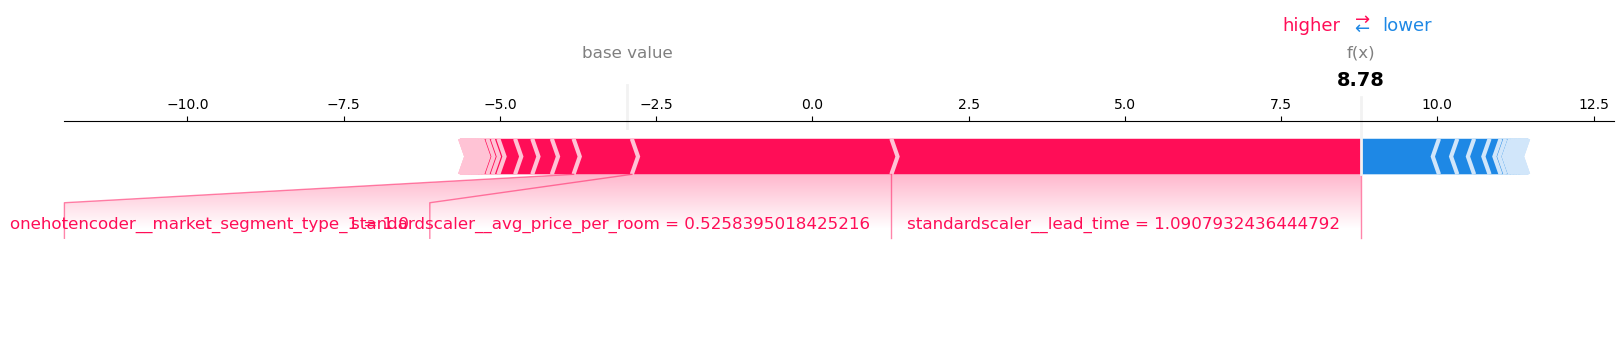

In [44]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_scaled)
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][canceled_ex_index, :],
    X_test_scaled.iloc[canceled_ex_index, :],
    matplotlib=True,
)

The base value for class 1 (or the average raw score) is -2.966. We see the forces that drive the prediction from the base value. Features that push the prediction to a higher value (shown in red) have an overall stronger effect than features on the opposite side. The most important feature for this prediction is `lead_time`, followed by `avg_price_per_room`.

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>

In [45]:
print("Accuracy:", pipe_rfe.score(X_test, y_test))
print("Recall:", recall_score(y_test, pipe_rfe.predict(X_test)))

Accuracy: 0.8814773980154355
Recall: 0.8064250411861614


I was able to improve the performance of the Reservation Cancellation Prediction model by optimizing for recall while also looking at accuracy. During the process, I have added some useful features, transformed the data, and trained various models, ultimately choosing LightGBM as the best one for the task. I also have used RFECV to select features, reducing the number of features from 70 to 50 while improving performance, and RandomizedSearchCV to fine-tune the hyperparameters. This has led to good results on both validation and test sets, suggesting that the model can generalize well on unseen data. The feature importance analysis using eli5 provided valuable insights into what drives cancellations in this dataset. It's interesting to note that `lead_time` and `average_price_per_room` emerged as the two most important features, as they reflect the customer's level of flexibility and the price sensitivity, respectively.

There might be other ideas that I could try to further improve performance and interpretability. For example, I could experiment with different types of feature engineering, such as creating interaction terms or using embeddings to represent categorical variables. Additionally, I could explore more types of models or ensembles, such as CatBoost and XGBoost, to see if they can improve performance further. Finally, I could leverage techniques like LIME to generate local explanations that can help improve the interpretability and trustworthiness of the model.

<br><br><br><br>